# Prototype Half Term Report

## Introduction

In [1]:
import numpy as np
import pandas as pd
import pickle as pkl
from matplotlib import pyplot as plt

from functools import reduce
from operator import add

%matplotlib inline

In [2]:
f = open('data/cnn/cnn_dataset.pkl', 'rb')
data = pkl.load(f)
data = np.reshape(data, len(data))
f.close()

## Data Exploration

### Data layout

In [3]:
print("HIGHLIGHT:\t{}\nSTORY:\t{}".format(data[0]['highlights'][0], data[0]['story'][0]))

HIGHLIGHT:	syrian official obama climbed to the top of the tree doesnt know how to get down
STORY:	its official us president barack obama wants lawmakers to weigh in on whether to use military force in syria


In [4]:
len(data)

92579

In [5]:
data[0]

{'highlights': ['syrian official obama climbed to the top of the tree doesnt know how to get down',
  'obama sends a letter to the heads of the house and senate',
  'obama to seek congressional approval on military action against syria',
  'aim is to determine whether cw were used not by whom says un spokesman'],
 'story': ['its official us president barack obama wants lawmakers to weigh in on whether to use military force in syria',
  'obama sent a letter to the heads of the house and senate on saturday night hours after announcing that he believes military action against syrian targets is the right step to take over the alleged use of chemical weapons',
  'the proposed legislation from obama asks congress to approve the use of military force to deter disrupt prevent and degrade the potential for future uses of chemical weapons or other weapons of mass destruction',
  'its a step that is set to turn an international crisis into a fierce domestic political battle',
  'there are key que

#### Cleaning Functions

In [3]:
def data_to_df (list_, cutoff):
    """
    Converts CNN dataset to a pandas dataframe
    """
    def combine_l_in_d (dict_, cutoff, joiner):
        return {key:joiner.join(dict_[key][:cutoff]) for key in dict_}
    
    return pd.DataFrame([
        combine_l_in_d(x_i, cutoff, '\n') 
        for x_i in list_
    ])
    

In [4]:
%%time
# We only take the first few sentences of each story, 
# editors usually make these the most descriptive
df = data_to_df(data, 5)

# To indicate summary begin and end
df['highlights'] = df['highlights'].map(lambda text: '\t' + text + '.')
del data

Wall time: 641 ms


In [9]:
len(df['highlights'][0])

281

### Proportion summarised
#### Prep 

In [6]:
def dict_split_flatten (dict_):
    """
    For each key in a dict, splits their strings 
    and flattens them
    """
    def split_flatten_list (list_):
        """
        Splits all strings in list and 
        flattens the list of lists into a list of string
        """

        list_ = [string.split() for string in list_]
        flat_list_ = [elem for sublist in list_ for elem in sublist]
        return flat_list_
    
    dict_ = {key:split_flatten_list(dict_[key]) for key in dict_}
    return dict_


def len_each_key (dict_):
    """
    Find length of each list in a dictionary
    """
    return {key: len(dict_[key]) for key in dict_}

def prop_for_all_story (data):
    """
    Finds the porportion of the summarisation 
    verses story by length
    """
    return [
        list(elem.values())[1] / list(elem.values())[0] 
        if list(elem.values())[0] is not 0 
        else 0 
        for elem in data
    ]        

Flatten all lists, so we may find the number of elements for each key in every dictionary

In [7]:
%%time
cleandata = [dict_split_flatten(elem) for elem in data]
cleandata = [len_each_key(elem) for elem in cleandata]
proportions = prop_for_all_story(cleandata)

Wall time: 11.4 s


#### Result

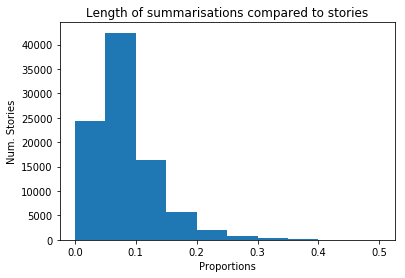

In [8]:
plt.hist(proportions, range=(0,0.5))
plt.title('Length of summarisations compared to stories')
plt.xlabel('Proportions')
plt.ylabel('Num. Stories')
plt.show()
del cleandata
del proportions

### Most popular words...
#### Prep

In [7]:
def pop_words(df, key, cutoff, stopwords=False):
    """
    Finds the most popular words from the data
    """
    from sklearn.feature_extraction.text import CountVectorizer
    
    if stopwords == False:
        cv = CountVectorizer(stop_words='english')
    else:
        cv = CountVectorizer()
        
    bag_of_words = cv.fit_transform(df[key])
    sum_words = bag_of_words.sum(axis=0)
    vocab = cv.vocabulary_.items()
    words_freq = [(word, sum_words[0, idx]) for word, idx in vocab]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:cutoff]

def plot_word_counts(key):
    words = list(zip(*pop[key]))[0]
    counts = list(zip(*pop[key]))[1]
    plt.xlabel('Counts')
    plt.ylabel('Words')
    plt.title('Most popular words for ' + key)
    return pd.Series(counts, index=words).plot.barh()

In [9]:
%%time
pop = {'highlights':None,
       'story':None}

pop = {key : pop_words(df,key, 10) 
       for key in pop}

Wall time: 38.3 s


#### Result

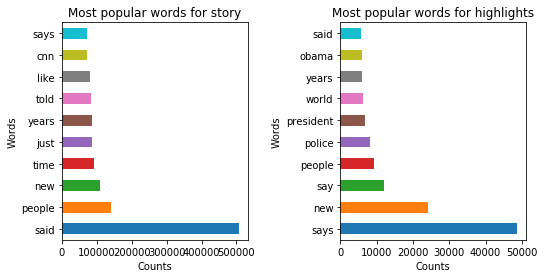

In [48]:
plt.subplots_adjust(right=1.2, wspace=0.5, hspace=0.5)
plt.subplot(1,2,1)
plot_word_counts('story')
plt.subplot(1,2,2)
plot_word_counts('highlights')
plt.show()

### Popular parts of speech tags for each key
#### Prep

In [16]:
from nltk import pos_tag, word_tokenize

def speech_tag_df(text):
    """
    Convert each text into only parts of speech tags
    """
    tag = pos_tag(word_tokenize(text))
    return [
        pos 
        for word, pos in tag
    ]

def pop_tags(df, key, cutoff, stopwords=False):
    """
    Finds the most popular words from the data
    """
    from sklearn.feature_extraction.text import CountVectorizer
    
    if stopwords == False:
        cv = CountVectorizer(stop_words='english')
    else:
        cv = CountVectorizer()
        
    bag_of_words = cv.fit_transform(tagged_df[key])
    sum_words = bag_of_words.sum(axis=0)
    vocab = cv.vocabulary_.items()
    words_freq = [(word, sum_words[0, idx]) for word, idx in vocab]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:cutoff]


def plot_tagged_counts(key):
    words = list(zip(*pop_tags_[key]))[0]
    counts = list(zip(*pop_tags_[key]))[1]
    plt.xlabel('Counts')
    plt.ylabel('Words')
    plt.title('Most popular tags for ' + key)
    return pd.Series(counts, index=words).plot.barh()

In [12]:
%%time
tagged_df = df.applymap(speech_tag_df)
tagged_df = tagged_df.applymap(lambda list_: ' '.join(list_))

Wall time: 44min 18s


In [14]:
%%time
pop_tags_ = {'highlights':None,
            'story':None}

pop_tags_ = {key : pop_tags(tagged_df,key, 10) for key in pop_tags_}

Wall time: 30.2 s


#### Result

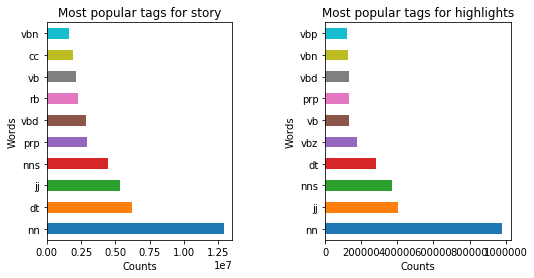

In [17]:
plt.subplots_adjust(right=1.2, wspace=0.5, hspace=0.5)
plt.subplot(1,2,1)
plot_tagged_counts('story')
plt.subplot(1,2,2)
plot_tagged_counts('highlights')
plt.show()

## Baseline
#### Prep

In [11]:
%%time
X_chars = set(char for text in df['story'] for char in text)
y_chars = set(char for text in df['highlights'] for char in text)

X_chars = sorted(list(X_chars))
y_chars = sorted(list(y_chars))

seqlen_X = max([len(text) for text in df['story']])
seqlen_y = max([len(text) for text in df['highlights']])

# I added '1' as last params for enumerate to account for 0 as equivalent 
# to a none value
char_index_X = dict([(char, i) for i,char in enumerate(X_chars, 1)])
char_index_y = dict([(char, i) for i,char in enumerate(y_chars, 1)])
index_char_X = dict([(i, char) for i,char in enumerate(X_chars, 1)])
index_char_y = dict([(i, char) for i,char in enumerate(y_chars, 1)])

Wall time: 4.9 s


#### Experiment with Tensors
All abandoned due to `MemoryErrors`.

In [6]:
def zeroes(n, index):
    arr = [0]*n
    arr[index] = 1
    return arr

In [23]:
test = df['highlights'].map(lambda text: [char_index_y[char] for char in text])


In [57]:
np.zeros((int(len(df)/2), seqlen_y, len(X_chars)))

MemoryError: 

In [45]:
foo = ([[0]*len(y_chars)]*seqlen_y).append([[0]*len(y_chars)]*seqlen_y)

In [41]:
test2 = [[0]*len(y_chars)]*seqlen_y
for i in range(len(df)):
    test2.append

In [32]:
# Wondering if I may append 2D Tensors onto each other without Memory costs
# As it appears that due to immutability of np.array appending to these may
# cause additional slow down
for t, char in enumerate(df['highlights'][0]):
    test2[0, t, char_index_y[char]] = 1
    
from keras.preprocessing.sequence import pad_sequences
test = pad_sequences(test, maxlen = seqlen_y, padding='post')

I wondered if I could use a list of pointer addresses to 2D lists to simulate a 3D list, and then append additional pointers onto the bigger list to work around `MemoryError`

Python does have to `id()` function

In [58]:
a = 2
id(a)

1525575168

However there's no native function to derefence this, and I'm hesitant to try additional packages as it may cause headache.

Then I realised that I could use character indexes converted to floats instead.

In [ ]:
test = df['highlights'].map(lambda text: [char_index_y[char] for char in text])
test = pad_sequences(test, maxlen = seqlen_y, padding='post')
enc_y = np.reshape(test, (len(df), seqlen_y, 1)) 

By doing this, I realised that I also had to start my character indexes from 1, to account for padded values.

In [67]:
enc_y = enc_y / float(len(y_chars))

In [70]:
enc_y[0][:5]

array([[0.        ],
       [0.4       ],
       [0.50909091],
       [0.38181818],
       [0.21818182]])

I only used our `y` as it was smaller than our `X`, in practice, we should assign `y` to categorical by the Keras function.

In [71]:
del enc_y, test

Let's try it with `X` instead

#### Prep for X

In [41]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

tmp = df['story'].map(lambda text: [char_index_X[char] for char in text])
tmp = pad_sequences(tmp, maxlen = seqlen_X, padding='post')
enc_X = np.reshape(tmp, (len(df), seqlen_X, 1))
enc_X = enc_X / float(len(X_chars))
del tmp

In [42]:
enc_X

array([[[0.10280374],
        [0.20560748],
        [0.19626168],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.21495327],
        [0.19626168],
        [0.02803738],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.20560748],
        [0.09345794],
        [0.06542056],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       ...,

       [[0.14953271],
        [0.1588785 ],
        [0.18691589],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.18691589],
        [0.06542056],
        [0.02803738],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.04672897],
        [0.14953271],
        [0.14953271],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]]])

#### Experiment for y

In [57]:
from sklearn.preprocessing import LabelBinarizer

tmp = list(df['highlights'].map(lambda text: [char_index_y[char] for char in text]))

In [71]:
enc_y = [to_categorical(char, num_classes=len(X_chars)) for text in tmp for char in text[:1]]

In [104]:
np.concatenate((np.zeros((2153,seqlen_y, len(X_chars))), 
 np.zeros((2153,seqlen_y, len(X_chars)))), axis=0)


MemoryError: 